# Load packages and set global settings

Imports and set up paths for output data.

In [1]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import pickle

print(sc.__version__)
print(anndata.__version__)

np.random.seed(seed=42)

1.10.3
0.10.9


In [2]:
# current working dir
root_dir = './'

# set output paths
results_dir = root_dir + 'results/'
dir_out = results_dir + 'figures/'
dir_anndata = results_dir + 'anndata/'
dir_tfmatrix = results_dir + 'csv/'
dir_model = results_dir + 'model/'

# Load data

Read the anndata object and 48TF matrix which will be used as labels and features in machine learning model respectively.

In [3]:
# read adata object and 48TF matrix
adata_obj_path = dir_anndata + 'adata_assigned_filtered.h5ad'
tf_matrix_path = dir_tfmatrix + 'tfmatrix_assigned_filtered.csv'

adata_assigned = sc.read_h5ad(adata_obj_path)  
csv_assigned_filter = pd.read_csv(tf_matrix_path, index_col=0)

print("read adata and TF matrix info sucessfully.")
print(f"AnnData shape: {adata_assigned.shape}")
print(f"TF matrix shape: {csv_assigned_filter.shape}")
print(f"\nCell types:")
print(adata_assigned.obs['assignment_z'].value_counts())

read adata and TF matrix info sucessfully.
AnnData shape: (26764, 36745)
TF matrix shape: (26764, 48)

Cell types:
assignment_z
Fibroblasts         11565
Collision           10235
Macrophages          4669
Epithelial cells      121
DC                    113
ILC                    61
Name: count, dtype: int64


# Predict cell types based on decision tree

A full-process machine learning pipeline based on custom wrapper classes (Estimator) covers the complete steps from data loading and dataset splitting, model initialization, hyperparameter tuning, training, to final evaluation. Here we initialize and train a decision tree model to predict cell reprogramming outcomes based on different TF combination input. The decision tree is also able to reveal the TF combinations-based cell reprogramming rules.

## Prepare dataset and model architecture

In [4]:
from estimator_v1 import Estimator
est_cl = Estimator(X_base=csv_assigned_filter, Y_base=adata_assigned)

est_cl.set_task("classification")
print(f"X shape: {est_cl.x.shape}")
print(f"Y shape: {est_cl.y.shape}")

est_cl.split_dataset(test_size=0.1, random_state=42)
print(f"Train size: {est_cl.X_cv.shape[0]}")
print(f"Test size: {est_cl.X_test.shape[0]}")

print("initializing model...")
est_cl.init_model("decision_tree")

X shape: (26764, 48)
Y shape: (26764,)
Train size: 24087
Test size: 2677
initializing model...


## Train model with tuning 

In [5]:
print("\nstarting model tuning...")
param_grid = {
    'max_depth': [10, 15, 20],         
    'min_samples_leaf': [1, 5, 10]   
}

est_cl.tune_sk(param_grid=param_grid, cv=5, n_jobs=-1)

print("\nmodel training")
est_cl.train()


starting model tuning...
No 'scoring' provided, using default: 'accuracy'
Running 5-fold CV search...
Tuning complete. Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1}
Best parameters set. Model is ready to be trained.

model training
sklearn model training complete.


In [6]:
# save model
model_path = dir_model + 'decision_tree_trained.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(est_cl.model, f)

print("Model saved successfully to decision_tree_trained.pkl")

Model saved successfully to decision_tree_trained.pkl


In [7]:
# load model
model_path = dir_model + 'decision_tree_trained.pkl'
with open(model_path, 'rb') as f:
    est_cl.model = pickle.load(f)

print("Model loaded successfully.")

Model loaded successfully.


## Prediction

In [8]:
print("starting evaluating...")
results, predictions = est_cl.evaluate(return_predictions=True)
print(f"evaluate results: {results}")

starting evaluating...
Test set accuracy: 0.4598
Generating predictions on 2677 test samples...
evaluate results: {'accuracy': 0.4598431079566679}


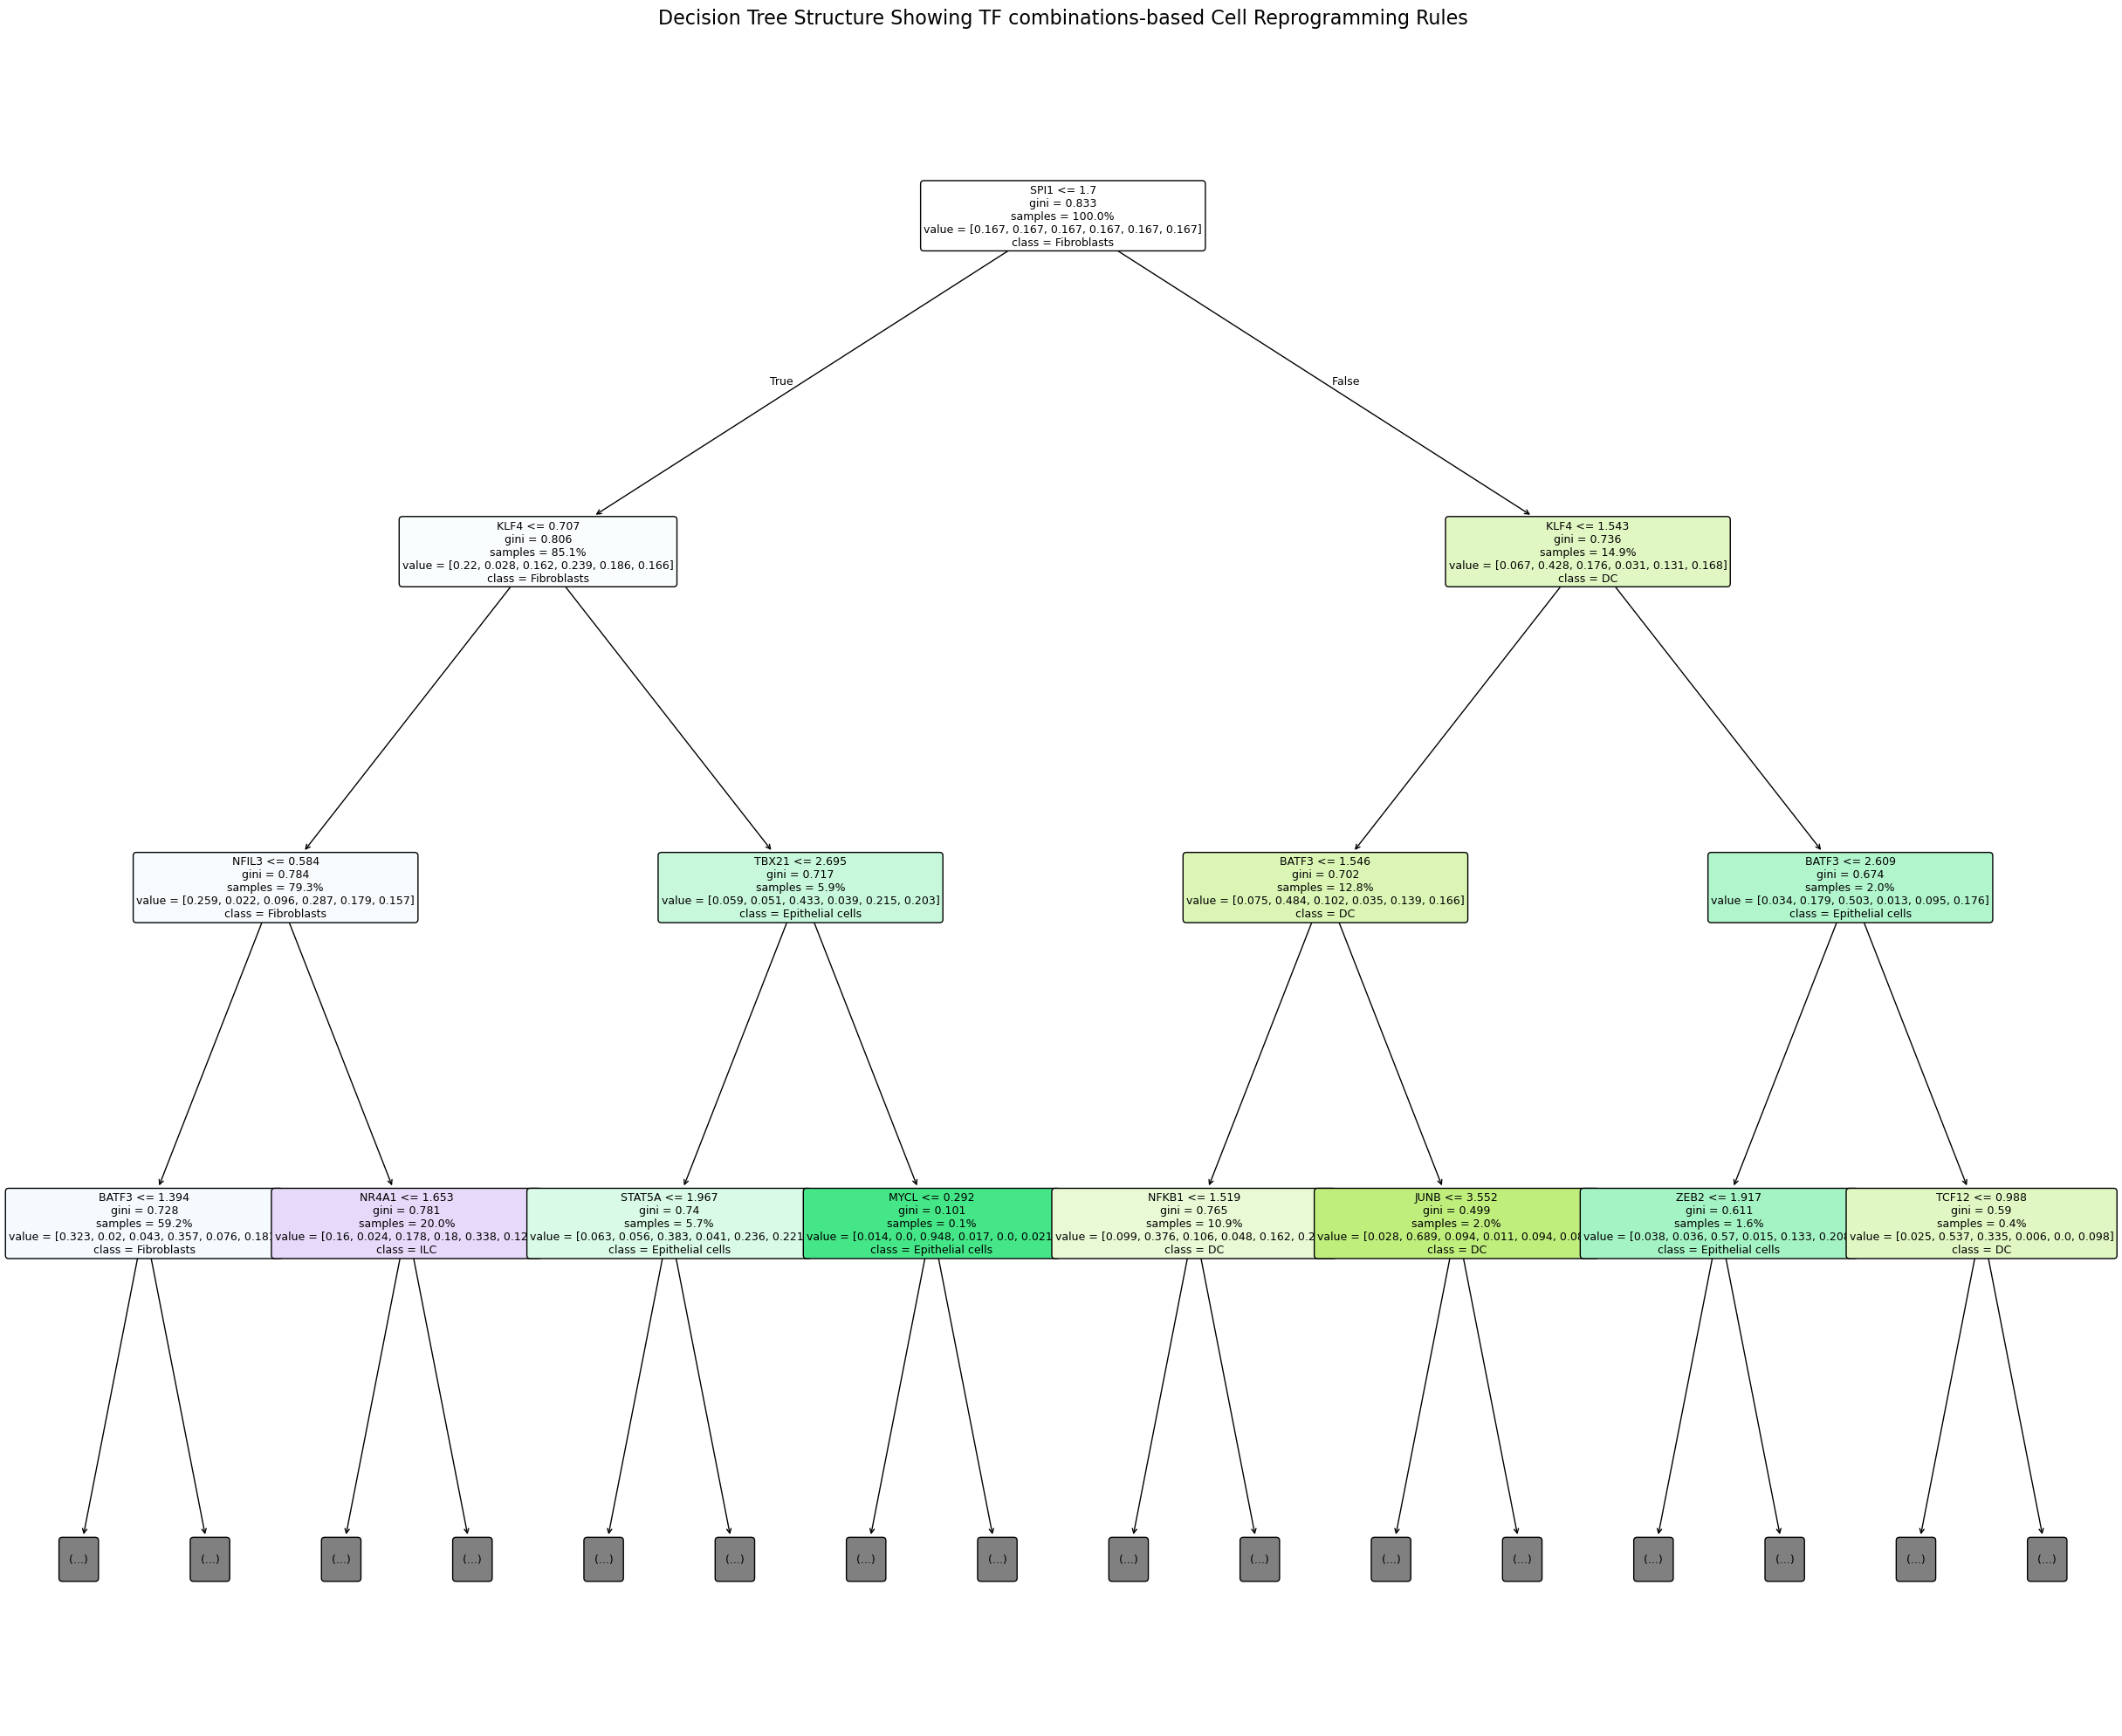

In [9]:
# plot the tree to find reprogramming rules
from sklearn.tree import plot_tree

fig=plt.figure(figsize=(25,20))
plot_tree(est_cl.model,
                   feature_names=csv_assigned_filter.columns.tolist(),
                   class_names=adata_assigned.obs['assignment_z'].astype('category').cat.categories.tolist(),
                   filled=True,
                   fontsize=9,
                   max_depth=3,
                   proportion=True,
                   rounded=True)
plt.title('Decision Tree Structure Showing TF combinations-based Cell Reprogramming Rules', 
         fontsize=16, pad=20)
plt.tight_layout()
plt.savefig(f"{dir_out}/decision_tree.png", dpi=300, bbox_inches='tight')
plt.show()

## Permutation test

Doing permutation test to check the model performance.


Running permutation test...
Real score = 0.443, p-value = 0.0010


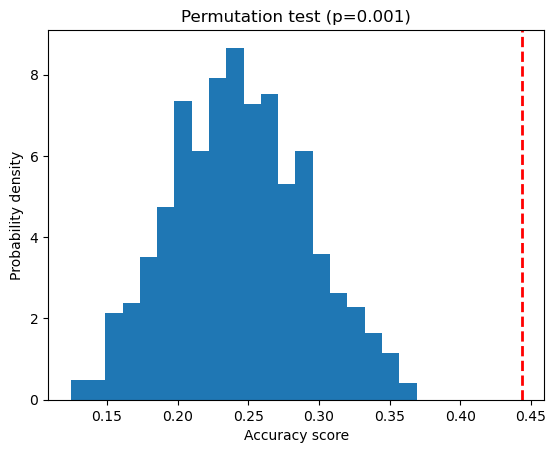

In [10]:
from sklearn.model_selection import permutation_test_score

print("\nRunning permutation test...")
score, perm_scores, pvalue = permutation_test_score(
    est_cl.model, 
    est_cl.X_cv,
    est_cl.Y_cv,
    scoring="accuracy" if est_cl.task == "classification" else "r2",
    cv=5,
    n_permutations=1000,
    n_jobs=-1,
)

print(f"Real score = {score:.3f}, p-value = {pvalue:.4f}")

plt.hist(perm_scores, bins=20, density=True)
plt.axvline(score, color='red', linestyle='--', linewidth=2)
plt.title(f"Permutation test (p={pvalue:.3f})")
plt.xlabel("Accuracy score")
plt.ylabel("Probability density")
plt.show()


## Blind test

Doing blind tests to test model generalizability and batch effect robustness.

In [11]:
# Blind test based on different batches: leave-one-sort-out cross-validation

unique_sorts = adata_assigned.obs['Sort'].unique()
print(f"Total sorts: {len(unique_sorts)}")
print(f"Sorts: {unique_sorts}")

Total sorts: 3
Sorts: ['Day2', 'DN', 'SP1']
Categories (3, object): ['DN', 'Day2', 'SP1']


In [12]:
from sklearn.metrics import accuracy_score

results = []

for blind_sort in unique_sorts:
    print(f"\n--- Testing on Sort = {blind_sort} ---")
    
    # split data by Sort
    train_mask = adata_assigned.obs['Sort'] != blind_sort
    test_mask = adata_assigned.obs['Sort'] == blind_sort
    
    adata_train = adata_assigned[train_mask, :].copy()
    adata_test = adata_assigned[test_mask, :].copy()
    
    tfmatrix_train = csv_assigned_filter.loc[adata_train.obs.index]
    tfmatrix_test = csv_assigned_filter.loc[adata_test.obs.index]
    
    print(f"Train: {adata_train.n_obs} cells")
    print(f"Test: {adata_test.n_obs} cells")

    # creat Estimator for blind tests
    est_blind = Estimator(X_base=tfmatrix_train, Y_base=adata_train)
    est_blind.set_task("classification")

    est_blind.X_cv = est_blind.x
    est_blind.Y_cv = est_blind.y
    
    # initialize the model with best params found before
    est_blind.init_model("decision_tree")
    
    best_params = {
    'max_depth': 20,           
    'min_samples_leaf': 1,     
    'class_weight': 'balanced'}
    est_blind.model.set_params(**best_params)
    
    # train
    est_blind.train()
    
    # predict
    y_pred = est_blind.model.predict(tfmatrix_test.values)
    
    # convert back to original tags 
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(adata_assigned.obs['assignment_z'])
    
    y_true_labels = adata_test.obs['assignment_z'].values
    y_true_encoded = le.transform(y_true_labels)
    
    # calculate acc for each test
    acc = accuracy_score(y_true_encoded, y_pred)
    print(f"Accuracy: {acc:.3f}")
    
    results.append({
        "Sort": blind_sort,
        "n_train": adata_train.n_obs,
        "n_test": adata_test.n_obs,
        "Accuracy": acc
    })

# summarize the results
results_df = pd.DataFrame(results)

print("Summary: Leave-One-Sort-Out Cross-Validation")
print(results_df.to_string(index=False))
print(f"\nMean accuracy: {results_df['Accuracy'].mean():.3f}")
print(f"Std accuracy: {results_df['Accuracy'].std():.3f}")
print(f"Min accuracy: {results_df['Accuracy'].min():.3f}")
print(f"Max accuracy: {results_df['Accuracy'].max():.3f}")


--- Testing on Sort = Day2 ---
Train: 18463 cells
Test: 8301 cells
sklearn model training complete.
Accuracy: 0.402

--- Testing on Sort = DN ---
Train: 13293 cells
Test: 13471 cells
sklearn model training complete.
Accuracy: 0.481

--- Testing on Sort = SP1 ---
Train: 21772 cells
Test: 4992 cells
sklearn model training complete.
Accuracy: 0.364
Summary: Leave-One-Sort-Out Cross-Validation
Sort  n_train  n_test  Accuracy
Day2    18463    8301  0.401879
  DN    13293   13471  0.481108
 SP1    21772    4992  0.363982

Mean accuracy: 0.416
Std accuracy: 0.060
Min accuracy: 0.364
Max accuracy: 0.481


In [13]:
# try batch correction

# create the batch corrected tf matrix (adata)
common_cells = csv_assigned_filter.index.intersection(adata_assigned.obs_names)
batch_info = adata_assigned.obs.loc[common_cells, 'Sort']
all_tfs = csv_assigned_filter.columns.tolist()
adata_tf = anndata.AnnData(
    X=csv_assigned_filter.loc[common_cells, all_tfs].values,
    obs=pd.DataFrame(index=common_cells)
)
adata_tf.obs['Sort'] = batch_info
adata_tf.var_names = all_tfs

# Combat correction
sc.pp.combat(adata_tf, key='Sort')

# convert back to pd data
tf_corrected_df = pd.DataFrame(
    adata_tf.X,
    index=common_cells,
    columns=all_tfs
)

In [14]:
est_cl_bt = Estimator(X_base=tf_corrected_df, Y_base=adata_assigned)

est_cl_bt.set_task("classification")
print(f"X shape: {est_cl_bt.x.shape}")
print(f"Y shape: {est_cl_bt.y.shape}")

est_cl_bt.split_dataset(test_size=0.1, random_state=42)
print(f"Train size: {est_cl_bt.X_cv.shape[0]}")
print(f"Test size: {est_cl_bt.X_test.shape[0]}")

print("initializing model...")
est_cl_bt.init_model("decision_tree")

X shape: (26764, 48)
Y shape: (26764,)
Train size: 24087
Test size: 2677
initializing model...


In [15]:
print("\nstarting model tuning...")
param_grid = {
    'max_depth': [10, 15, 20],         
    'min_samples_leaf': [1, 5, 10]   
}

est_cl_bt.tune_sk(param_grid=param_grid, cv=5, n_jobs=-1)

print("\nmodel training")
est_cl_bt.train()


starting model tuning...
No 'scoring' provided, using default: 'accuracy'
Running 5-fold CV search...
Tuning complete. Best parameters found: {'max_depth': 15, 'min_samples_leaf': 5}
Best parameters set. Model is ready to be trained.

model training
sklearn model training complete.


In [16]:
print("starting evaluating...")
results, predictions = est_cl_bt.evaluate(return_predictions=True)
print(f"evaluate results: {results}")

starting evaluating...
Test set accuracy: 0.4419
Generating predictions on 2677 test samples...
evaluate results: {'accuracy': 0.44191258871871497}


In [17]:
unique_sorts = adata_assigned.obs['Sort'].unique()
results = []

for blind_sort in unique_sorts:
    print(f"\n--- Testing on Sort = {blind_sort} ---")
    
    # split data by Sort
    train_mask = adata_assigned.obs['Sort'] != blind_sort
    test_mask = adata_assigned.obs['Sort'] == blind_sort
    
    adata_train = adata_assigned[train_mask, :].copy()
    adata_test = adata_assigned[test_mask, :].copy()
    
    tfmatrix_train = tf_corrected_df.loc[adata_train.obs.index]
    tfmatrix_test = tf_corrected_df.loc[adata_test.obs.index]
    
    print(f"Train: {adata_train.n_obs} cells")
    print(f"Test: {adata_test.n_obs} cells")

    # creat Estimator for blind tests
    est_blind = Estimator(X_base=tfmatrix_train, Y_base=adata_train)
    est_blind.set_task("classification")

    est_blind.X_cv = est_blind.x
    est_blind.Y_cv = est_blind.y
    
    # initialize the model with best params found before
    est_blind.init_model("decision_tree")
    
    best_params = {
    'max_depth': 15,           
    'min_samples_leaf': 5,     
    'class_weight': 'balanced'}
    est_blind.model.set_params(**best_params)
    
    # train
    est_blind.train()
    
    # predict
    y_pred = est_blind.model.predict(tfmatrix_test.values)
    
    # convert back to original tags 
    le = LabelEncoder()
    le.fit(adata_assigned.obs['assignment_z'])
    
    y_true_labels = adata_test.obs['assignment_z'].values
    y_true_encoded = le.transform(y_true_labels)
    
    # calculate acc for each test
    acc = accuracy_score(y_true_encoded, y_pred)
    print(f"Accuracy: {acc:.3f}")
    
    results.append({
        "Sort": blind_sort,
        "n_train": adata_train.n_obs,
        "n_test": adata_test.n_obs,
        "Accuracy": acc
    })

# summarize the results
results_df = pd.DataFrame(results)

print("Summary: Leave-One-Sort-Out Cross-Validation")
print(results_df.to_string(index=False))
print(f"\nMean accuracy: {results_df['Accuracy'].mean():.3f}")
print(f"Std accuracy: {results_df['Accuracy'].std():.3f}")
print(f"Min accuracy: {results_df['Accuracy'].min():.3f}")
print(f"Max accuracy: {results_df['Accuracy'].max():.3f}")


--- Testing on Sort = Day2 ---
Train: 18463 cells
Test: 8301 cells
sklearn model training complete.
Accuracy: 0.207

--- Testing on Sort = DN ---
Train: 13293 cells
Test: 13471 cells
sklearn model training complete.
Accuracy: 0.493

--- Testing on Sort = SP1 ---
Train: 21772 cells
Test: 4992 cells
sklearn model training complete.
Accuracy: 0.338
Summary: Leave-One-Sort-Out Cross-Validation
Sort  n_train  n_test  Accuracy
Day2    18463    8301  0.207324
  DN    13293   13471  0.492614
 SP1    21772    4992  0.338141

Mean accuracy: 0.346
Std accuracy: 0.143
Min accuracy: 0.207
Max accuracy: 0.493


# Downstream analysis

Downstream analyses include: finding top 10 important TFs for determining the cell reprogramming outcomes based on decision tree; performing differential gene expression (DEG) analysis to confirm that model-predicted DCs exhibit a global DC-specific transcriptomic signature; identifying and validating the decision tree rule-based DCs. We also specifically evaluate 2 canonical markers, PTPRC and HLA-DRA, to verify if the specific TF threshold combinations extracted from the decision tree could really successfully induce a high-confidence DC phenotype distinct from other cells.

## Top 10 important TFs

Top 10 important TF:
        TF  Importance
24    SPI1    0.112230
0    NFIL3    0.087520
21    KLF4    0.084011
19   BATF3    0.068750
5    NR4A1    0.057619
1     MYCL    0.039999
8     JUNB    0.035887
12  ARID5A    0.033934
13   NFKB1    0.032401
20    HHEX    0.027268


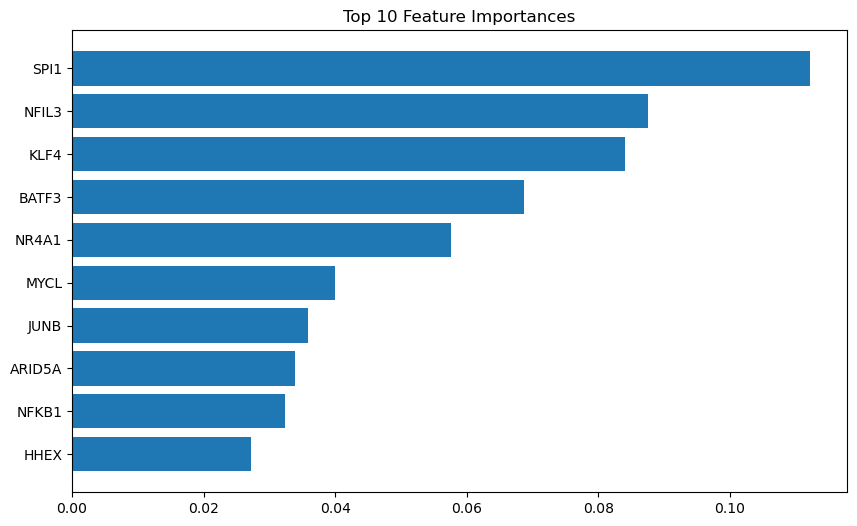

In [18]:
# Finding the top10 important TFs to determine cell reprogramming results

# obtain feature importance
importances = est_cl.model.feature_importances_
feature_names = csv_assigned_filter.columns

# create a DataFrame and sort it
feature_imp = pd.DataFrame({'TF': feature_names, 'Importance': importances})
feature_imp = feature_imp.sort_values('Importance', ascending=False)

# print the top10 TFs
print("Top 10 important TF:")
print(feature_imp.head(10))

# plot
plt.figure(figsize=(10, 6))
plt.barh(feature_imp['TF'].head(10), feature_imp['Importance'].head(10))
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances")
plt.savefig(f"{dir_out}/Top_tfs.png", dpi=300, bbox_inches='tight')
plt.show()

## DEG analysis to validate the model-predicted DCs

In [19]:
# predict cell types based on decision tree
dt_pred = est_cl.model.predict(csv_assigned_filter.values)
adata_assigned.obs['DT_pred'] = pd.Categorical(dt_pred)

In [20]:
# convert the predicted numerical indices back to the original cell type names
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(adata_assigned.obs['assignment_z'])
adata_assigned.obs['DT_pred'] = le.inverse_transform(adata_assigned.obs['DT_pred'])
adata_assigned.obs['DT_pred'] = adata_assigned.obs['DT_pred'].astype('category')

print(adata_assigned.obs['DT_pred'].value_counts())

DT_pred
Fibroblasts         14894
Collision            7160
Macrophages          4070
DC                    282
ILC                   197
Epithelial cells      161
Name: count, dtype: int64


In [21]:
# DEG analysis to identify DC-specific marker genes based on decision tree predictions
sc.tl.rank_genes_groups(
    adata_assigned,
    groupby='DT_pred',
    groups=['DC'], # focus on DC
    reference='rest', # compare DC with other cell types
    method='wilcoxon',
    use_raw=False
)

dt_dc_degs = sc.get.rank_genes_groups_df(
    adata_assigned,
    group='DC',
    key='rank_genes_groups'
)
print("\nTop 20 markers for DT Predicted DC:")
print(dt_dc_degs[['names', 'logfoldchanges', 'pvals_adj']].head(20))


Top 20 markers for DT Predicted DC:
              names  logfoldchanges      pvals_adj
0               GRN        2.601959  1.586381e-123
1              CD74        5.032624  1.578620e-115
2              CST3        2.873551  1.764783e-114
3             PTPRC        3.721083  1.635549e-113
4               LYN        2.372989  1.635549e-113
5              PSAP        1.861269  1.685697e-110
6               B2M        1.877348  1.504421e-108
7           METTL7A        3.258747  2.631655e-106
8              UCP2        3.314317  3.783178e-105
9               OS9        1.520470  3.412244e-104
10             NPC2        1.859984  7.453785e-103
11            HLA-C        2.036156  1.212488e-101
12            HLA-B        2.218494  1.544885e-101
13             CTSS        2.920769   5.877228e-99
14           SAMD9L        2.548932   4.667895e-98
15             PRCP        2.025528   8.525811e-98
16         ATP6V0E1        1.054268   6.141800e-97
17            TXNIP        3.065156   7.70905

## Decision tree rule-based DCs identification and validation

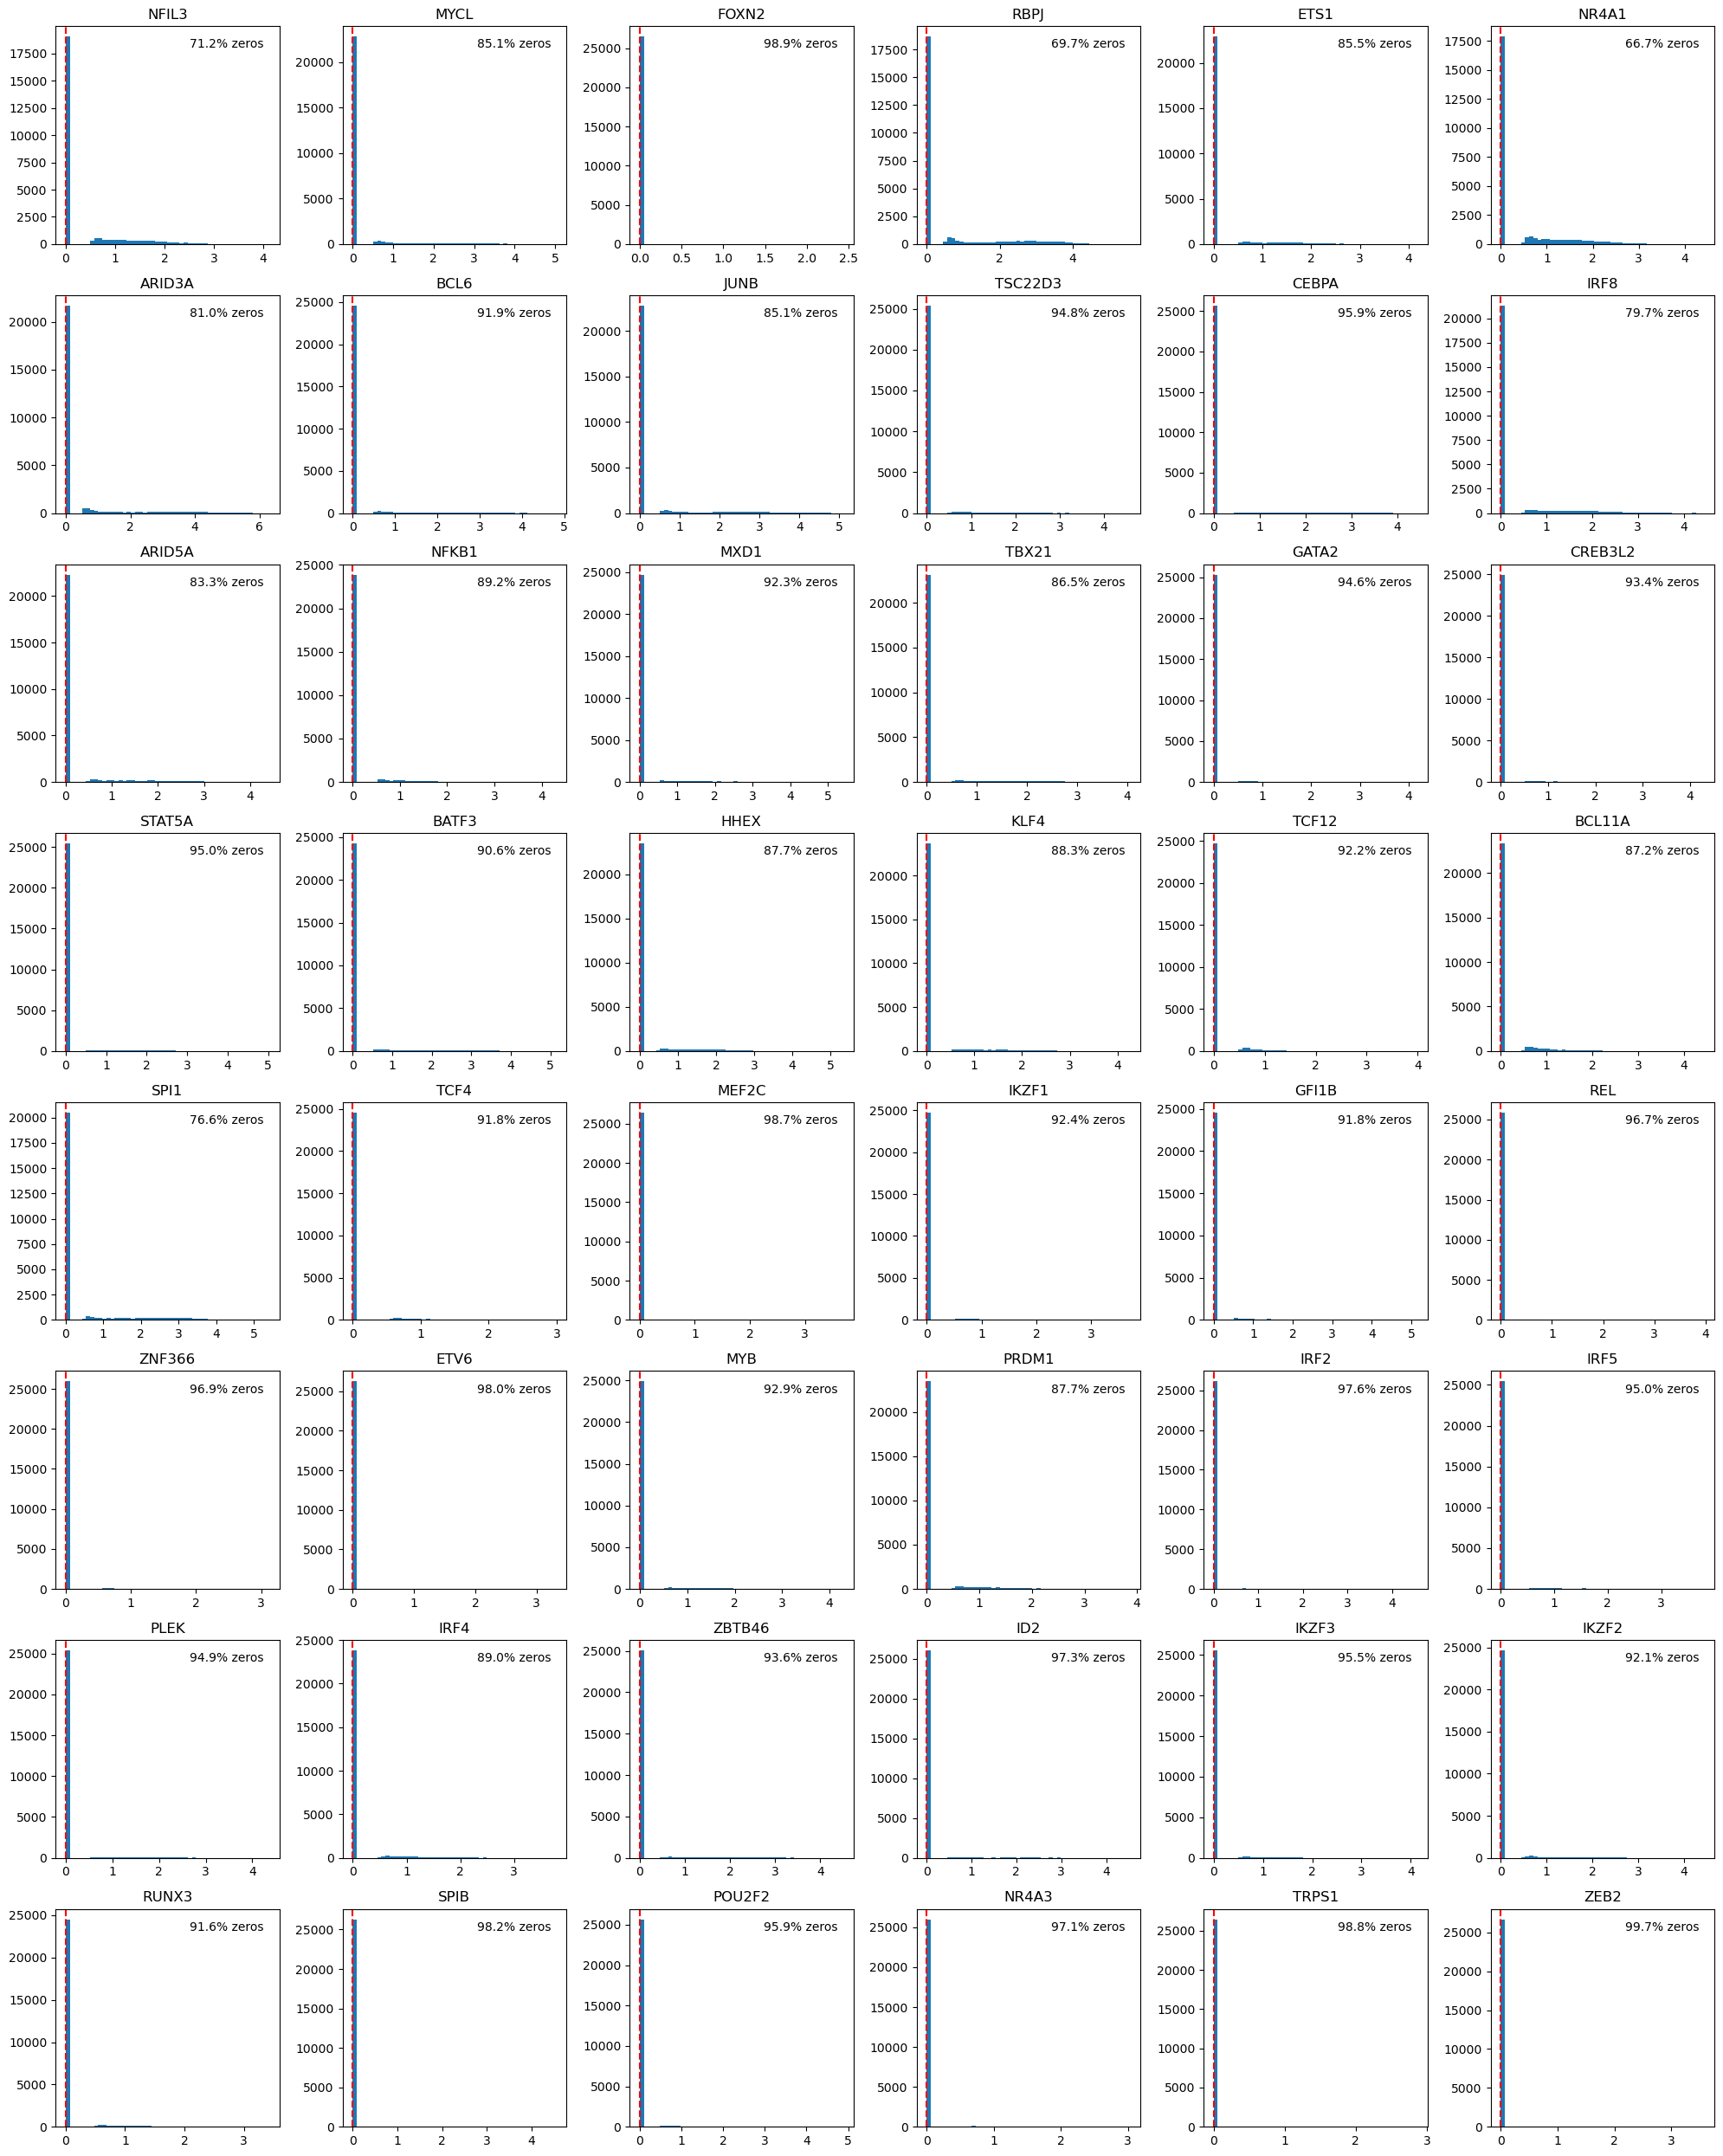

In [22]:
# View the expression distribution of all 48 TFs
fig, axes = plt.subplots(8, 6, figsize=(20, 25))
axes = axes.ravel()

for i, tf in enumerate(csv_assigned_filter.columns):
    axes[i].hist(csv_assigned_filter[tf], bins=50)
    axes[i].set_title(tf)
    axes[i].axvline(0, color='red', linestyle='--')
     
    # Calculate the proportion of zero values
    zero_pct = (csv_assigned_filter[tf] == 0).sum() / len(csv_assigned_filter) * 100
    axes[i].text(0.6, 0.9, f'{zero_pct:.1f}% zeros', 
                 transform=axes[i].transAxes)

plt.tight_layout()
plt.show()

In [23]:
# check whether there are sufficient cells with effective TF combination to reprogram DCs found by decision tree  
both_pos = (csv_assigned_filter['SPI1'] > 0) & (csv_assigned_filter['KLF4'] > 0)
print(f"co-expression cells for SPI1+KLF4: {both_pos.sum()} ({both_pos.sum()/len(csv_assigned_filter)*100:.1f}%)")

tri_pos = (csv_assigned_filter['SPI1'] > 0) & (csv_assigned_filter['KLF4'] > 0) & (csv_assigned_filter['BATF3'] > 0)
print(f"co-expression cells for SPI1+KLF4+BATF3: {tri_pos.sum()} ({tri_pos.sum()/len(csv_assigned_filter)*100:.1f}%)")

co-expression cells for SPI1+KLF4: 1668 (6.2%)
co-expression cells for SPI1+KLF4+BATF3: 611 (2.3%)


In [24]:
# binary classification of cells based on transformed SPI1 expression levels
SPI1_th = 1.7

csv_assigned_filter["SPI1_sp"] = np.where(csv_assigned_filter['SPI1'] > SPI1_th, "valid", "invalid")
mask_SPI1 = adata_assigned.obs_names.intersection(csv_assigned_filter.index)
adata_assigned.obs["SPI1_sp"] = csv_assigned_filter.loc[mask_SPI1, "SPI1_sp"].reindex(adata_assigned.obs_names)

In [25]:
# binary classification of cells based on transformed SPI1 and KLF4 expression levels
SPI1_th = 1.7
KLF4_th = 1.543

csv_assigned_filter["SPI1_KLF4_sp"] = np.where((csv_assigned_filter['SPI1'] > SPI1_th) & (csv_assigned_filter['KLF4'] < KLF4_th), "valid", "invalid")
mask_SPI1_KLF4 = adata_assigned.obs_names.intersection(csv_assigned_filter.index)
adata_assigned.obs["SPI1_KLF4_sp"] = csv_assigned_filter.loc[mask_SPI1_KLF4, "SPI1_KLF4_sp"].reindex(adata_assigned.obs_names)

In [26]:
# binary classification of cells based on transformed SPI1, KLF4 and BATF3 expression levels
SPI1_th = 1.7
KLF4_th = 1.543
BATF3_th = 1.546

csv_assigned_filter["SPI1_KLF4_BATF3_sp"] = np.where((csv_assigned_filter['SPI1'] > SPI1_th) & (csv_assigned_filter['KLF4'] < KLF4_th) & (csv_assigned_filter['BATF3'] > BATF3_th), 
                                                     "valid", "invalid")
mask_SPI1_KLF4_BATF3 = adata_assigned.obs_names.intersection(csv_assigned_filter.index)
adata_assigned.obs["SPI1_KLF4_BATF3_sp"] = csv_assigned_filter.loc[mask_SPI1_KLF4_BATF3, "SPI1_KLF4_BATF3_sp"].reindex(adata_assigned.obs_names)

/home/inf-48-2024/anaconda3/envs/cellrp/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


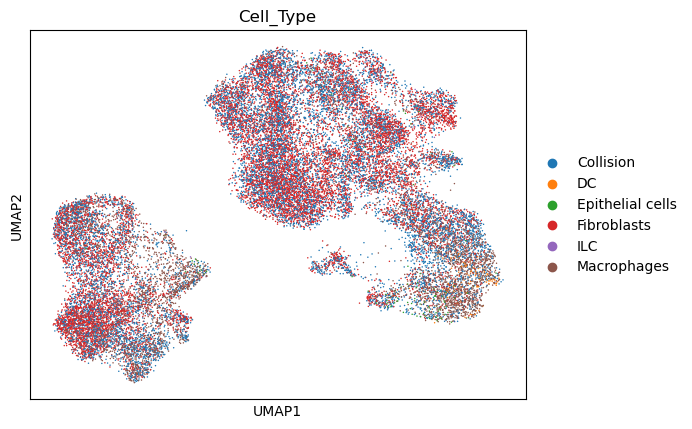

In [27]:
# dimensionality reduction clustering and visualization

sc.pp.highly_variable_genes(adata_assigned, flavor='cell_ranger', n_top_genes=3000)
sc.pp.pca(adata_assigned, n_comps=50, random_state=42, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_assigned, n_neighbors=30, knn=True, method='umap', n_pcs=50, random_state=0)
sc.tl.umap(adata_assigned)

sc.settings.figdir = dir_out
adata_assigned.obs['Cell_Type'] = adata_assigned.obs['assignment_z']
sc.pl.umap(adata_assigned, color=["Cell_Type"], save='_celltypes.png')

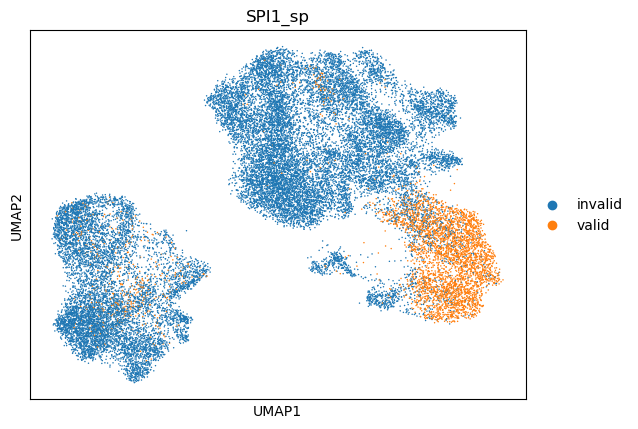

In [28]:
sc.pl.umap(adata_assigned, color=["SPI1_sp"], save='_SPI1.png')

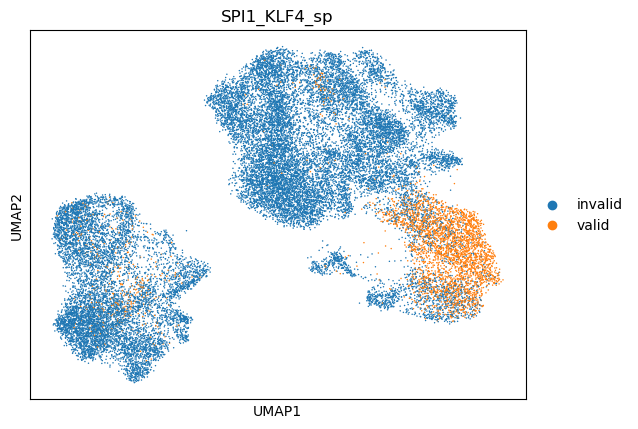

In [29]:
sc.pl.umap(adata_assigned, color=["SPI1_KLF4_sp"], save='_SPI1_KLF4.png')

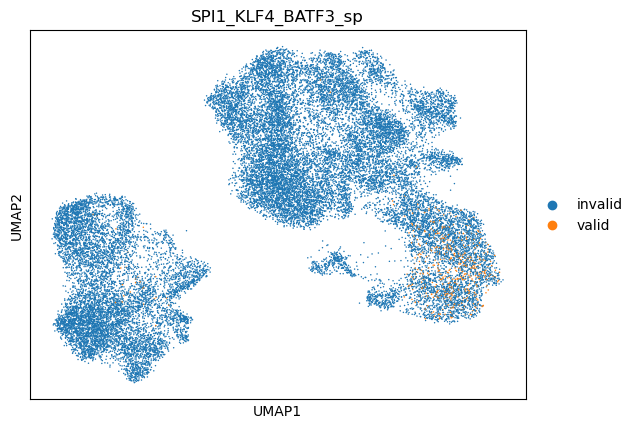

In [30]:
sc.pl.umap(adata_assigned, color=["SPI1_KLF4_BATF3_sp"], save='_SPI1_KLF4_BATF3.png')

### Inspect marker expression level

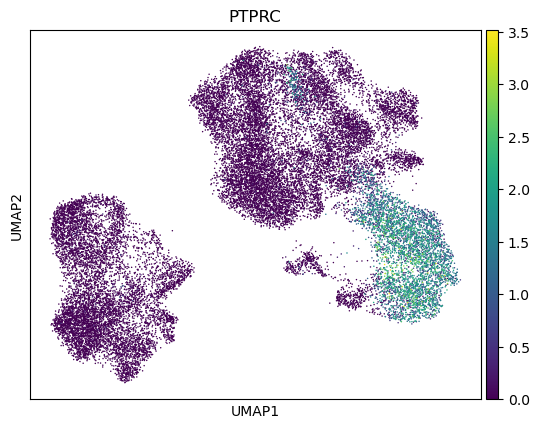

In [31]:
sc.pl.umap(adata_assigned, color='PTPRC', use_raw=False, save='_PTPRC_exp.png')

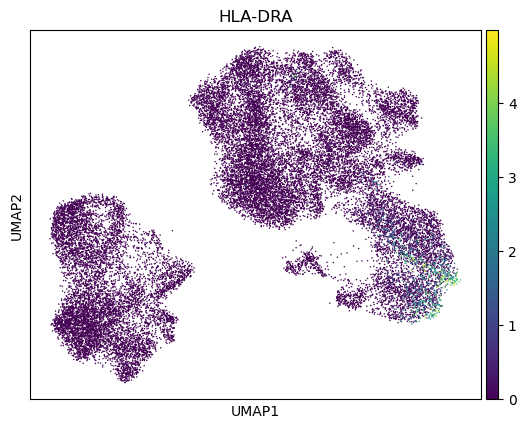

In [32]:
sc.pl.umap(adata_assigned, color='HLA-DRA', use_raw=False, save='_HLA-DRA_exp.png')

In [33]:
# select high quality predicted DCs matching condition found by decision tree rules
adata_assigned.obs['DT_pred_rule'] = adata_assigned.obs['DT_pred'].astype(str)

rule_mask_series = (csv_assigned_filter['SPI1'] > 1.7) & (csv_assigned_filter['KLF4'] < 1.543) & (csv_assigned_filter['BATF3'] > 1.546)
common_cells = adata_assigned.obs_names.intersection(csv_assigned_filter.index)
aligned_rule_mask = rule_mask_series.loc[common_cells].reindex(adata_assigned.obs_names, fill_value=False)

# if DCs match the rule, name it as 'DC_High_Conf'
mask_final = (adata_assigned.obs['DT_pred_rule'] == 'DC') & aligned_rule_mask
adata_assigned.obs.loc[mask_final, 'DT_pred_rule'] = 'DC_High_Conf'

# otherwise name it 'DC_rest'
mask_rest_dc = (adata_assigned.obs['DT_pred_rule'] == 'DC') & (~aligned_rule_mask)
adata_assigned.obs.loc[mask_rest_dc, 'DT_pred_rule'] = 'DC_rest'

adata_assigned.obs['DT_pred_rule'] = adata_assigned.obs['DT_pred_rule'].astype('category')
print(adata_assigned.obs['DT_pred_rule'].value_counts())

DT_pred_rule
Fibroblasts         14894
Collision            7160
Macrophages          4070
ILC                   197
Epithelial cells      161
DC_High_Conf          148
DC_rest               134
Name: count, dtype: int64


/tmp/ipykernel_4063318/4195753821.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = marker_stats.groupby('cell_type').agg({
/tmp/ipykernel_4063318/4195753821.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dfg, x='cell_type', y=target_gene,
/tmp/ipykernel_4063318/4195753821.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')
/tmp/ipykernel_4063318/4195753821.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` varia

                  PTPRC_mean  PTPRC_median  PTPRC_%pos  HLA_mean  HLA_median  \
cell_type                                                                      
Collision               0.28           0.0       21.94      0.07        0.00   
DC_High_Conf            1.56           1.6       96.62      0.94        0.08   
DC_rest                 1.27           1.3       89.55      1.06        0.00   
Epithelial cells        0.45           0.0       34.78      0.13        0.00   
Fibroblasts             0.06           0.0        5.93      0.01        0.00   
ILC                     0.21           0.0       16.75      0.07        0.00   
Macrophages             0.65           0.0       46.44      0.19        0.00   

                  HLA_%pos  
cell_type                   
Collision             6.49  
DC_High_Conf         50.00  
DC_rest              44.78  
Epithelial cells     16.15  
Fibroblasts           1.75  
ILC                   4.57  
Macrophages          15.09  
Gene: PTPRC | Glob

/tmp/ipykernel_4063318/4195753821.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')


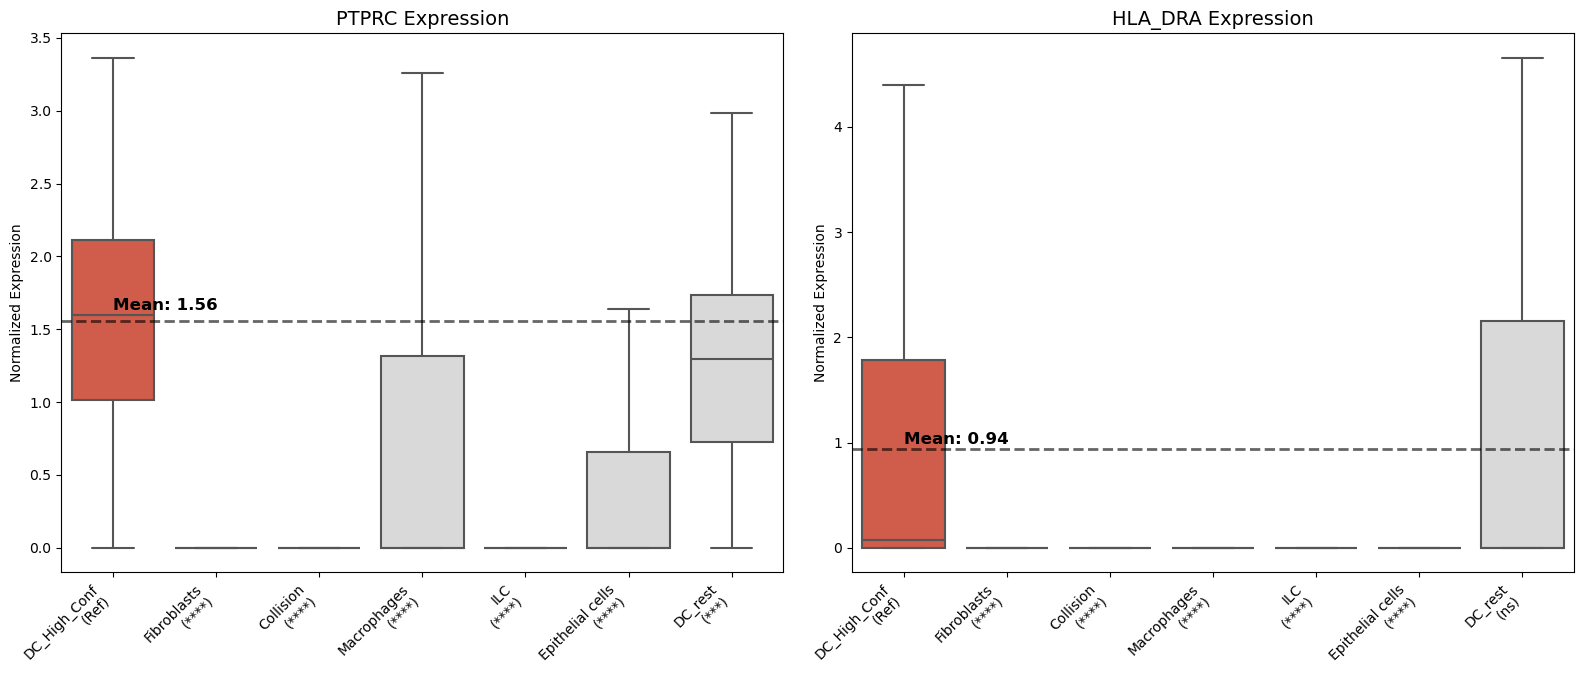

In [34]:
import seaborn as sns
from scipy.stats import kruskal, mannwhitneyu

# extract 2 markers: PTPRC and HLA-DRA expression levels from all cells
ptprc_all = adata_assigned[:, 'PTPRC'].X.toarray().flatten()
hla_all = adata_assigned[:, 'HLA-DRA'].X.toarray().flatten()

# merging marker details with predicted cell types
marker_stats = pd.DataFrame({
    'cell_type': adata_assigned.obs['DT_pred_rule'],
    'PTPRC': ptprc_all,
    'HLA_DRA': hla_all
})

# statistics analysis
summary = marker_stats.groupby('cell_type').agg({
    'PTPRC': ['mean', 'median', lambda x: (x>0).mean()*100],
    'HLA_DRA': ['mean', 'median', lambda x: (x>0).mean()*100]
})
summary.columns = ['PTPRC_mean', 'PTPRC_median', 'PTPRC_%pos', 
                   'HLA_mean', 'HLA_median', 'HLA_%pos']
print(summary.round(2))

# plotting
# set parameters
genes = ['PTPRC', 'HLA_DRA']
ref_group = 'DC_High_Conf'  # 'DC_High_Conf' as the ref group to compare with each other group
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.set_theme(style="whitegrid")
my_palette = {cat: "#d9d9d9" for cat in marker_stats['cell_type'].unique()} 
if ref_group in my_palette:
    my_palette[ref_group] = "#E64B35"

for i, target_gene in enumerate(genes):
    ax = axes[i]
    
    # create new dataframe for marker
    dfg = marker_stats[['cell_type', target_gene]].copy()
    groups = dfg['cell_type'].unique()
    
    # glabal test (Kruskal-Wallis)
    data_by_group = [dfg[dfg['cell_type'] == g][target_gene].values for g in groups]
    stat, p_global = kruskal(*data_by_group)
    print(f"Gene: {target_gene} | Global Kruskal-Wallis P-value: {p_global:.2e}")

    # pairwise test (Mann-Whitney U)
    new_labels_dict = {}
    
    for g in groups:
        if g == ref_group:
            new_labels_dict[g] = f"{g}\n(Ref)"
            continue
            
        # extract data for reference group and other comparision groups
        data_ref = dfg[dfg['cell_type'] == ref_group][target_gene]
        data_other = dfg[dfg['cell_type'] == g][target_gene]
        
        # test if Ref > Other
        stat, p_val = mannwhitneyu(data_ref, data_other, alternative='greater') # hypothesis: Ref expression ('DC_High_Conf') > Other expression
        
        # p-value -> "*"
        if p_val < 0.0001: star = "****"
        elif p_val < 0.001: star = "***"
        elif p_val < 0.01: star = "**"
        elif p_val < 0.05: star = "*"
        else: star = "ns"
        
        new_labels_dict[g] = f"{g}\n({star})"
    
    # Boxplot
    order_list = [ref_group] + [g for g in groups if g != ref_group]
    
    sns.boxplot(data=dfg, x='cell_type', y=target_gene, 
                order=order_list, palette=my_palette, 
                ax=ax, showfliers=False, linewidth=1.5)
    
    col_name = f"{target_gene.replace('_DRA', '')}_mean" 
    if target_gene == 'HLA_DRA': col_name = 'HLA_mean'
    else: col_name = 'PTPRC_mean'
        
    mean_val = summary.loc[ref_group, col_name]
    
    ax.axhline(y=mean_val, color='black', linestyle='--', alpha=0.6, linewidth=2)
    ax.text(x=0, y=mean_val*1.05, s=f'Mean: {mean_val:.2f}', color='black', fontweight='bold')

    current_labels = [label.get_text() for label in ax.get_xticklabels()]
    new_labels = [new_labels_dict[label] for label in current_labels]
    ax.set_xticklabels(new_labels, rotation=45, ha='right')

    ax.set_title(f'{target_gene} Expression', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Normalized Expression')

plt.tight_layout()
plt.savefig(f"{dir_out}/markers_statistics.png", dpi=300, bbox_inches='tight')
plt.show()